In [17]:
!curl -L -o /content/flowers-recognition.zip\
  https://www.kaggle.com/api/v1/datasets/download/alxmamaev/flowers-recognition

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  224M  100  224M    0     0  17.3M      0  0:00:12  0:00:12 --:--:-- 21.6M


In [2]:
!curl -L -o /content/test_flower.jpg https://blog.giulianaflores.com.br/wp-content/uploads/2021/08/girassol-2-scaled.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247k  100  247k    0     0   297k      0 --:--:-- --:--:-- --:--:--  297k


In [83]:
!curl -L -o /content/black_white_flower.jpg https://cdn.pixabay.com/photo/2013/08/09/05/52/sunflower-170961_1280.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  209k  100  209k    0     0   120k      0  0:00:01  0:00:01 --:--:--  120k


In [ ]:
!unzip flowers-recognition.zip -d flowers

In [54]:
from platform import python_version
print('Versão do Python neste Notebook:', python_version())

Versão do Python neste Notebook: 3.12.11


In [55]:
!pip install -q tensorflow

In [56]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [57]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

In [58]:
import os
from PIL import Image

data_dir = "/content/flowers/flowers"

for root, dirs, files in os.walk(data_dir):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception as e:
                print(f"Imagem corrompida removida: {file_path} ({e})")
                os.remove(file_path)


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/content/flowers/flowers"
image_size = (64, 64)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

nomes_classes = list(train_generator.class_indices.keys())

imagens_vis, labels_vis = next(train_generator)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


## Pré-processamento e Visualização das imagens

In [60]:
import matplotlib.pyplot as plt

In [61]:
def visualiza_imagens(images, labels, nomes_classes):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(nomes_classes[int(labels[i])])
    plt.show()


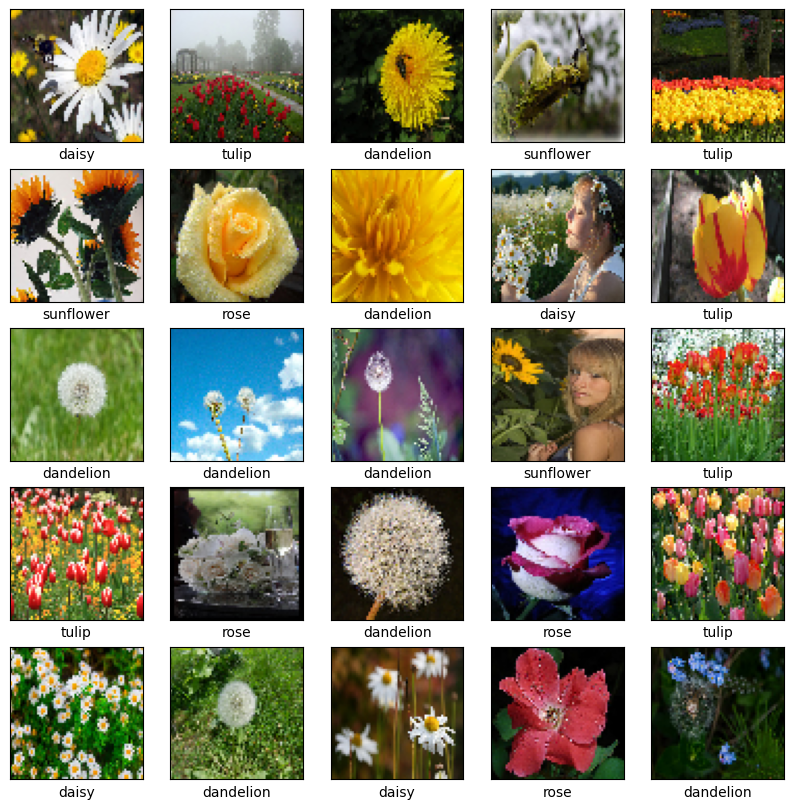

In [62]:
visualiza_imagens(imagens_vis, labels_vis, nomes_classes)


## Construção do Modelo

In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
num_classes = len(nomes_classes)

In [33]:
from tensorflow.keras import layers, models

modelo = models.Sequential([
    layers.Input(shape=(64, 64, 3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [34]:
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,388,517 (9.11 MB)

 Trainable params: 2,387,109 (9.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [37]:
history = modelo.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.4148 - loss: 1.7886 - val_accuracy: 0.2442 - val_loss: 6.3489
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5396 - loss: 1.2371 - val_accuracy: 0.2442 - val_loss: 11.4281
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.5953 - loss: 1.0901 - val_accuracy: 0.3058 - val_loss: 2.5793
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6265 - loss: 1.0277 - val_accuracy: 0.3209 - val_loss: 2.5936
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6298 - loss: 0.9713 - val_accuracy: 0.6070 - val_loss: 1.0311
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.6923 - loss: 0.8290 - val_accuracy: 0.5628 - val_loss: 1.2472
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.7341 - loss: 0.6927 - val_accuracy: 0.6674 - val_loss: 0.8786
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.7210 - loss: 0.7335 - val

In [38]:
test_loss, test_acc = modelo.evaluate(validation_generator)
print(f"Acurácia no teste: {test_acc:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6876 - loss: 0.8644
Acurácia no teste: 0.6942


## Avaliação do modelo

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


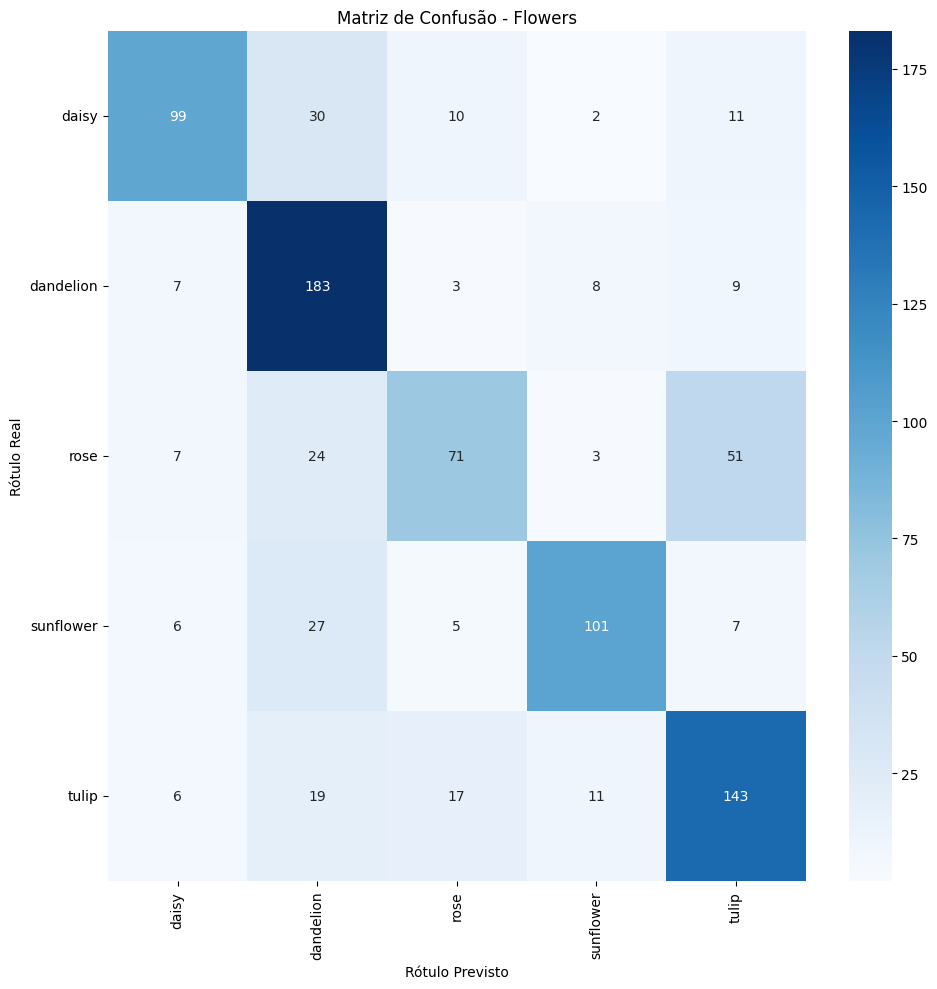

              precision    recall  f1-score   support

       daisy       0.79      0.65      0.71       152
   dandelion       0.65      0.87      0.74       210
        rose       0.67      0.46      0.54       156
   sunflower       0.81      0.69      0.75       146
       tulip       0.65      0.73      0.69       196

    accuracy                           0.69       860
   macro avg       0.71      0.68      0.69       860
weighted avg       0.70      0.69      0.69       860



In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Previsões
y_pred = modelo.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Valores reais
y_true = validation_generator.classes

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nomes_classes,
            yticklabels=nomes_classes)

plt.title('Matriz de Confusão - Flowers')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Relatório detalhado
print(classification_report(y_true, y_pred_classes, target_names=nomes_classes))


## Deploy do modelo

In [84]:
nova_imagem = Image.open("/content/black_white_flower.jpg")

In [85]:
nova_imagem.size

(1280, 857)

In [86]:
largura = nova_imagem.width
altura = nova_imagem.height

In [87]:
print("A largura da imagem é: ", largura)
print("A altura da imagem é: ", altura)

A largura da imagem é:  1280
A altura da imagem é:  857


In [88]:
nova_imagem = nova_imagem.resize((64, 64))

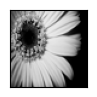

In [89]:
plt.figure(figsize = (1,1))
plt.imshow(nova_imagem)
plt.xticks([])
plt.yticks([])
plt.show()

In [90]:
nova_imagem_array = np.array(nova_imagem) / 255.0

In [91]:
nova_imagem_array = np.expand_dims(nova_imagem_array, axis = 0)

In [92]:
previsoes = modelo.predict(nova_imagem_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [93]:
print(previsoes)

[[0.27025458 0.11867166 0.41373703 0.01839055 0.17894611]]


In [94]:
classe_prevista = np.argmax(previsoes)
nome_classe_prevista = nomes_classes[classe_prevista]
confianca = previsoes[0][classe_prevista] * 100

In [95]:
print("Essa flor é uma:", nome_classe_prevista)
print(f"Com uma confiança de: {confianca:.2f}%")

Essa flor é uma: rose
Com uma confiança de: 41.37%
